# Change backbone to MobileNet
### First, setup libraries

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
tensorboard = SummaryWriter()

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
# plt.rcParams['text.usetex'] = True  # Render Matplotlib text with Tex
from PIL import Image
from sklearn.model_selection import train_test_split
import time

import cv2


### Prepare data

In [2]:
# Define the data to be used
DATASET = "./datasets/dataset_3+8bags_3var3sc/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        # Count the number of files in the image directory
        # return len(os.listdir(self.images_directory))
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.loc[idx, "image_id"])
        
        # Read the image
        image = Image.open(image_name)
        
        # Eventually apply transforms to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.loc[idx, "traversal_cost"]
        
        # Get the corresponding traversability label
        traversability_label = self.traversal_costs_frame.loc[idx, "traversability_label"]

        return image, traversal_cost, traversability_label

In [3]:
def compute_mean_std(images_directory, traversal_costs_file):
    transform = transforms.Compose([
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize((70, 210)),

        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
    ])
    
    # Create a Dataset for training
    dataset = TraversabilityDataset(
        traversal_costs_file=DATASET+traversal_costs_file,
        images_directory=DATASET+images_directory,
        transform=transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=1,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    cnt = 0
    first_moment = torch.empty(3)
    second_moment = torch.empty(3)

    for images, traversal_costs, traversability_labels in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        first_moment = (cnt * first_moment + sum_) / (cnt + nb_pixels)
        second_moment = (cnt * second_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean = first_moment
    std = torch.sqrt(second_moment - first_moment ** 2)
    
    return mean, std

In [4]:
mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
print(mean, std)

tensor([0.3426, 0.3569, 0.2914]) tensor([0.1363, 0.1248, 0.1302])


In [5]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Modify the brightness and the contrast of the image
    transforms.ColorJitter(contrast=0.5, brightness=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Add some random gaussian noise to the image
    transforms.Lambda(lambda x: x + (0.001**0.5)*torch.randn(x.shape)),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    # transforms.Resize(100),
    transforms.Resize((70, 210)),
    # transforms.Grayscale(),
    # transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=mean,
        std=std,
        # mean=[0.485, 0.456, 0.406],
        # std=[0.229, 0.224, 0.225],
    ),
])


# # Create a Dataset instance for our training data
# data = TraversabilityDataset(
#     traversal_costs_file=DATASET+"traversal_costs.csv",
#     images_directory=DATASET+"images",
#     transform=train_transform
# )

# # Split our training dataset into a training dataset and a validation dataset
# train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=train_transform
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_train.csv",
    images_directory=DATASET+"images_train",
    transform=test_transform
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs_test.csv",
    images_directory=DATASET+"images_test",
    transform=test_transform
)

# Set the train dataset size
# 70% of the total data is used for training, 15% for validation
# and 15% for testing
train_size = 70/(100-15)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(range(len(train_set)), train_size=train_size)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


BATCH_SIZE = 32

# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [6]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [7]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)")
print(f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)")
print(f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)")

70.0 % of the data for training (6239 samples)
15.0 % of the data for validation (1337 samples)
15.0 % of the data for testing (1338 samples)


### GPU?

In [8]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



### Model design and initialization

In [9]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained MobileNet model
model = models.mobilenet_v2(pretrained=True).to(device=device)

# Replace the last layer by a fully-connected one with 1 output
model.classifier[1] = nn.Linear(model.last_channel, 1).to(device=device)

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.classifier[1].weight)

# Display the architecture in TensorBoard
images, traversal_costs, traversability_labels = next(iter(train_loader))
images = images.to(device)
tensorboard.add_graph(model, images)

# Print the modified model
print(model)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

### Training and validation loops

In [10]:


# Define the loss function
criterion = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [param for name, param in model.named_parameters()
               if name not in ["classifier.1.weight", "classifier.1.bias"]]

# Define the optimizer, with a greater learning rate for the new fc layer
optimizer = optim.SGD([
    {"params": base_params},
    {"params": model.classifier.parameters(), "lr": 1e-3},
],
    lr=1e-3, momentum=0.9, weight_decay=0.001)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 100

# Number of epochs we wait for the loss to decrease before stopping
# the training process early
patience = 10

best_val_loss = float('inf')
best_epoch = 0

loss_values = torch.zeros(2, NB_EPOCHS)

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_costs, _ in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (update weights)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    # (turn off dropout layers, batchnorm layers, etc)
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Turn off gradients computation (the backward computational graph is built during
    # the forward pass and weights are updated during the backward pass, here we avoid
    # building the graph)
    with torch.no_grad():
        # Loop over the validation batches
        for images, traversal_costs, _ in val_loader_pbar:

            # Print the epoch and validation mode
            val_loader_pbar.set_description(f"Epoch {epoch} [val]")

            # Move images and traversal scores to GPU (if available)
            images = images.to(device)
            traversal_costs = traversal_costs.type(torch.FloatTensor).to(device)
            
            # Perform forward pass (only, no backpropagation)
            predicted_traversal_costs = model(images)

            # Compute loss
            loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
            # Print the batch loss next to the progress bar
            val_loader_pbar.set_postfix(batch_loss=loss.item())

            # Accumulate batch loss to average over the epoch
            val_loss += loss.item()
            
    
    # Compute the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print("Train loss: ", train_loss)
    print("Validation loss: ", val_loss)
    
    # Store the computed losses
    loss_values[0, epoch] = train_loss
    loss_values[1, epoch] = val_loss
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss, epoch)
    tensorboard.add_scalar("val_loss", val_loss, epoch)
    
    # Early stopping based on validation loss: stop the training if the
    # loss has not improved for the last 5 epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

# Close TensorBoard
tensorboard.close()

Epoch 0 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.49batch/s, batch_loss=0.0507]


Train loss:  0.36281601312832956
Validation loss:  0.1442838673080717


Epoch 1 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.68batch/s, batch_loss=0.149] 


Train loss:  0.11164980163941017
Validation loss:  0.1061162543261335


Epoch 2 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.80batch/s, batch_loss=0.0595]


Train loss:  0.08871714281730163
Validation loss:  0.0873978224893411


Epoch 3 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.16batch/s, batch_loss=0.0743]


Train loss:  0.07518534582012738
Validation loss:  0.08451639479469686


Epoch 4 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.96batch/s, batch_loss=0.0828]


Train loss:  0.07015788298195753
Validation loss:  0.07665552402890864


Epoch 5 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.45batch/s, batch_loss=0.0567]


Train loss:  0.06576384671796591
Validation loss:  0.0821743875387169


Epoch 6 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.10batch/s, batch_loss=0.106] 


Train loss:  0.06579391413774245
Validation loss:  0.0690343396826869


Epoch 7 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.09batch/s, batch_loss=0.0517]


Train loss:  0.060101541781272645
Validation loss:  0.059132762696771396


Epoch 8 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.47batch/s, batch_loss=0.0709]


Train loss:  0.059124393913990415
Validation loss:  0.061727012551966165


Epoch 9 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.77batch/s, batch_loss=0.0403]


Train loss:  0.05914178229868412
Validation loss:  0.06325899729771274


Epoch 10 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.55batch/s, batch_loss=0.0521]


Train loss:  0.057318581965489265
Validation loss:  0.06351196969903651


Epoch 11 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.94batch/s, batch_loss=0.0595]


Train loss:  0.056959050740951145
Validation loss:  0.061175567142310594


Epoch 12 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.21batch/s, batch_loss=0.0424]


Train loss:  0.055620211477463065
Validation loss:  0.062049913175758864


Epoch 13 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.47batch/s, batch_loss=0.0655]


Train loss:  0.05421142516036828
Validation loss:  0.06154721718104113


Epoch 14 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.26batch/s, batch_loss=0.0767]


Train loss:  0.054212986859373556
Validation loss:  0.0569526052900723


Epoch 15 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.95batch/s, batch_loss=0.0379]


Train loss:  0.05440179174527144
Validation loss:  0.05677450146703493


Epoch 16 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.42batch/s, batch_loss=0.0532]


Train loss:  0.05291803803008336
Validation loss:  0.053251618962912334


Epoch 17 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.96batch/s, batch_loss=0.0387]


Train loss:  0.05435436765352885
Validation loss:  0.05672091152518988


Epoch 18 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.69batch/s, batch_loss=0.0799]


Train loss:  0.05180748235911895
Validation loss:  0.05093321683151381


Epoch 19 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.08batch/s, batch_loss=0.1]   


Train loss:  0.05243951184436297
Validation loss:  0.050275636393399464


Epoch 20 [val]: 100%|██████████| 42/42 [00:00<00:00, 56.41batch/s, batch_loss=0.0389]


Train loss:  0.05201527255181319
Validation loss:  0.0562112404565726


Epoch 21 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.59batch/s, batch_loss=0.0358]


Train loss:  0.050541476828929705
Validation loss:  0.05094274603539989


Epoch 22 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.97batch/s, batch_loss=0.0504]


Train loss:  0.049946146859572486
Validation loss:  0.05348977952131203


Epoch 23 [val]: 100%|██████████| 42/42 [00:00<00:00, 56.43batch/s, batch_loss=0.037] 


Train loss:  0.049674129696228565
Validation loss:  0.05303961406683638


Epoch 24 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.04batch/s, batch_loss=0.0862]


Train loss:  0.051326952998836835
Validation loss:  0.05725682455868948


Epoch 25 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.31batch/s, batch_loss=0.051] 


Train loss:  0.04966649106488778
Validation loss:  0.050061402132823354


Epoch 26 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.94batch/s, batch_loss=0.0337]


Train loss:  0.05033729483301823
Validation loss:  0.04884885721618221


Epoch 27 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.41batch/s, batch_loss=0.0711]


Train loss:  0.047881896220720734
Validation loss:  0.05073238217404911


Epoch 28 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.85batch/s, batch_loss=0.0287]


Train loss:  0.0491150197883447
Validation loss:  0.050776259352763496


Epoch 29 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.71batch/s, batch_loss=0.0541]


Train loss:  0.04882433259716401
Validation loss:  0.05297428653353736


Epoch 30 [val]: 100%|██████████| 42/42 [00:00<00:00, 59.07batch/s, batch_loss=0.0425]


Train loss:  0.04835145228948349
Validation loss:  0.05205750762529317


Epoch 31 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.58batch/s, batch_loss=0.0512]


Train loss:  0.04867420631150405
Validation loss:  0.05237605928310326


Epoch 32 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.44batch/s, batch_loss=0.0311]


Train loss:  0.04804013963693227
Validation loss:  0.04928052984178066


Epoch 33 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.61batch/s, batch_loss=0.0355]


Train loss:  0.049218901179921934
Validation loss:  0.05052381585396472


Epoch 34 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.47batch/s, batch_loss=0.0315]


Train loss:  0.047634182402338736
Validation loss:  0.047338349744677544


Epoch 35 [val]: 100%|██████████| 42/42 [00:00<00:00, 55.91batch/s, batch_loss=0.0413]


Train loss:  0.04796107676930916
Validation loss:  0.04757003823206538


Epoch 36 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.52batch/s, batch_loss=0.0256]


Train loss:  0.04624804722575041
Validation loss:  0.047932034047941365


Epoch 37 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.50batch/s, batch_loss=0.0551]


Train loss:  0.046040873191295524
Validation loss:  0.04968527287599586


Epoch 38 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.26batch/s, batch_loss=0.0588]


Train loss:  0.046732174089321725
Validation loss:  0.051197112670966556


Epoch 39 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.71batch/s, batch_loss=0.0594]


Train loss:  0.04561169065344028
Validation loss:  0.04785453319726955


Epoch 40 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.38batch/s, batch_loss=0.0374]


Train loss:  0.04649401809542607
Validation loss:  0.045927832346586955


Epoch 41 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.99batch/s, batch_loss=0.0595]


Train loss:  0.04606855667363375
Validation loss:  0.04887339831995113


Epoch 42 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.44batch/s, batch_loss=0.0257]


Train loss:  0.04541314494533417
Validation loss:  0.04707181012435328


Epoch 43 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.62batch/s, batch_loss=0.0308]


Train loss:  0.04543885320233993
Validation loss:  0.04892560564691112


Epoch 44 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.47batch/s, batch_loss=0.0473]


Train loss:  0.04507409908259526
Validation loss:  0.05274895383488564


Epoch 45 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.86batch/s, batch_loss=0.0375]


Train loss:  0.04785466541846593
Validation loss:  0.049877678886765524


Epoch 46 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.84batch/s, batch_loss=0.0334]


Train loss:  0.04550086959050252
Validation loss:  0.05074301770045644


Epoch 47 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.71batch/s, batch_loss=0.0365]


Train loss:  0.044282891219243024
Validation loss:  0.05002757454557078


Epoch 48 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.66batch/s, batch_loss=0.0359]


Train loss:  0.044929463788866995
Validation loss:  0.046282230698991386


Epoch 49 [val]: 100%|██████████| 42/42 [00:00<00:00, 58.05batch/s, batch_loss=0.0295]


Train loss:  0.04464751856449323
Validation loss:  0.04664261337547075


Epoch 50 [val]: 100%|██████████| 42/42 [00:00<00:00, 57.70batch/s, batch_loss=0.0318]

Train loss:  0.04414912099735095
Validation loss:  0.047767767017441135
Early stopping at epoch 50


### Visualization

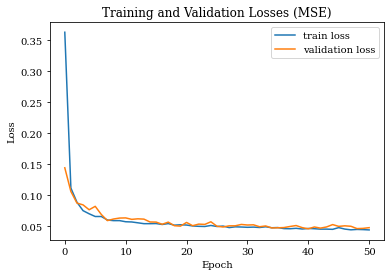

In [11]:
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt

# Loss
indices = loss_values[0] != 0
train_losses = loss_values[0][indices]
val_losses = loss_values[1][indices]

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses (MSE)")
plt.show()

### Testing

In [12]:
# Testing
test_loss = 0.

# Configure the model for testing
model.eval()

with torch.no_grad():
    # Loop over the testing batches
    for images, traversal_costs, _ in test_loader:
        
        images = images.to(device)
        traversal_costs = traversal_costs.to(device)
        
        # Perform forward pass
        predicted_traversal_costs = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_costs[:, 0], traversal_costs)
        
        # Accumulate batch loss to average of the entire testing set
        test_loss += loss.item()
        
# Compute the loss and accuracy
test_loss /= len(test_loader)

print("Test loss: ", test_loss)

Test loss:  0.04919623183883936


In [13]:
images, traversal_costs, _ = next(iter(test_loader))

images = images.to(device)
traversal_costs = traversal_costs.to(device)

predicted_traversal_scores = model(images)
# predicted_traversal_scores = nn.Softmax(dim=1)(model(images))

print("Output:\n", predicted_traversal_costs)
print("Ground truth:\n", traversal_costs)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)

Output:
 tensor([[1.9067],
        [1.3779],
        [1.8289],
        [1.8622],
        [1.8467],
        [1.6435],
        [1.7196],
        [1.7600],
        [1.7562],
        [1.8696],
        [1.4030],
        [1.4746],
        [1.8216],
        [1.8370],
        [1.5567],
        [1.9565],
        [1.5578],
        [1.7571],
        [1.9623],
        [1.4862],
        [1.8262],
        [1.6685],
        [1.4711],
        [1.8584],
        [1.7102],
        [1.4451]], device='cuda:0')
Ground truth:
 tensor([1.4431, 1.8142, 1.4213, 1.8988, 1.6864, 1.0896, 1.3164, 1.1830, 1.9168,
        1.0740, 1.7578, 1.9497, 1.1054, 1.4927, 2.1730, 1.6349, 1.9143, 1.6020,
        1.8331, 2.0072, 1.7344, 1.1041, 1.8847, 1.4045, 0.9980, 2.2835, 1.8514,
        1.1247, 2.0487, 1.2955, 1.9082, 1.9524], device='cuda:0',
       dtype=torch.float64)


In [ ]:
traversal_costs_train = []

for _, score, _ in train_set:
    traversal_costs_train.append(score)
    
plt.hist(traversal_costs_train, bins=10)
plt.xlabel("Traversal Cost")
plt.ylabel("Count")
plt.title("Histogram of Traversal Costs (Training Set)")
plt.show()

### Save model parameters

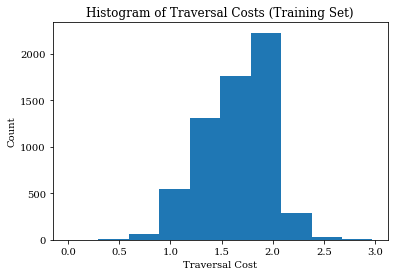

In [14]:
# Save the model parameters
torch.save(model.state_dict(), "v2_mobilenet.params")